In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [111]:
# Measurment table columns
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [112]:
# Station table columns
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [ ]:
for row in session.query(Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).limit(5):
    print(row)

In [ ]:
# Query for station and measurment table
hawaii = pd.read_sql(session.query(Station.name.label("S_station_name"),
                          Station.latitude.label("S_lat"),
                          Station.longitude.label("S_lon"),
                          Station.elevation.label("S_station_elevation"),
                          Measurement.station.label("M_station"), 
                          Measurement.date.label("M_date"), 
                          Measurement.prcp.label("M_prcp"), 
                          Measurement.tobs.label("M_tobs")).filter(Station.id == Measurement.id).limit(10).statement, engine)
hawaii

#### Smallest or oldest date point in the database

In [97]:
# Smallest or oldesr date point in the database
session.query(Measurement.date,Measurement.prcp).order_by(Measurement.date).first()

('2010-01-01', 0.08)

#### Largest or most recent date point in the database

In [98]:
# Largest or fitst date point in the database
session.query(Measurement.date,Measurement.prcp).order_by(Measurement.date.desc()).first()

('2017-08-23', 0.0)

# Exploratory Climate Analysis
##### Design a query to retrieve the last 12 months of precipitation data and plot the results
##### Calculate the date 1 year ago from the last data point in the database
#### Perform a query to retrieve the data and precipitation scores

In [ ]:
climate_ana = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date)

#### Save the query results as a Pandas DataFrame and set the index to the date column

In [ ]:
climate_df = pd.DataFrame(climate_ana)

climate_df = climate_df.set_index(['date'])

#### Sort the dataframe by date

In [ ]:
# Sort the dataframe by date
climate_df.sort_index

#### Use Pandas Plotting with Matplotlib to plot the data

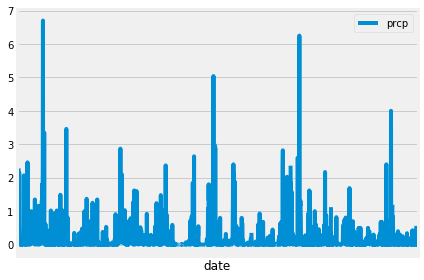

In [119]:
climate_df.plot()
plt.xticks([])
plt.tight_layout()
plt.show()

# Use Pandas to calcualte the summary statistics for the precipitation data

In [100]:
climate_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Design a query to show how many stations are available in this dataset?

In [116]:
# Design a query to show how many stations are available in this dataset?
s_count = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).count()
print(f"There are {s_count} stations available in this dataset")

There are 9 stations available in this dataset


# What are the most active stations? (i.e. what stations have the most rows)?
#### List the stations and the counts in descending order.


In [140]:
# locations = session.query(Demo).group_by(Demo.location).count()
# print(locations)
station_count = (Measurement.station, func.count(Measurement.station))
act_stat = session.query(*station_count).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
active_stations = act_stat.all()
most_active_stat = act_stat.first()[0]
print(f"most active station is {most_active_stat}")
active_stations

most active station is USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

# Using the station id from the previous query, calculate the lowest temperature recorded,highest temperature recorded, and average temperature of the most active station?

In [143]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query = f'''
SELECT MIN(tobs), MAX(tobs), AVG(tobs) 
FROM measurement 
WHERE station = "{most_active_stat}"
'''
act_stat_query = engine.execute(query).fetchall()
act_stats = act_stat_query
act_stats

[(54.0, 85.0, 71.66378066378067)]

### Choose the station with the highest number of temperature observations.
#### Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [163]:
station_temp = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == "USC00519281").order_by(Measurement.date)
# Convert to DF
station_temp_df = pd.DataFrame(station_temp)
station_temp_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


### Using pandas.DataFrame.plot.hist to plot histogram

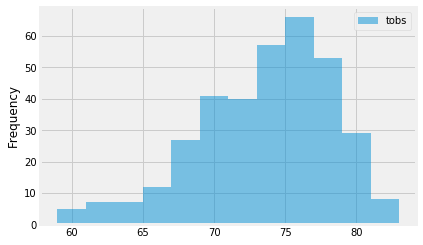

In [164]:
ax = station_temp_df.plot.hist(bins=12, alpha=0.5)

### This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' and return the minimum, average, and maximum temperatures for that range of d

In [165]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


### Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.

In [172]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2016-08-23', '2017-08-23')
t_min = trip[0][0]
t_avg = trip[0][1]
t_max = trip[0][2]
print(f'Min: {t_min}, Avg: {t_avg}, and Max: {t_max}')

Min: 58.0, Avg: 74.59058295964125, and Max: 87.0


## Plot the results from your previous query as a bar chart. 
#### Use "Trip Avg Temp" as your Title
#### Use the average temperature for the y value
#### Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


Text(0, 0.5, 'Average Temp')

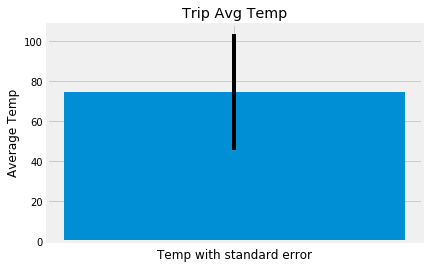

In [175]:
#trip_yaxis = trip_stats[0][1]

error = t_max - t_min

plt.bar('',t_avg,yerr = error, align = 'center')
plt.title('Trip Avg Temp')
plt.xlabel('Temp With Standard Error')
plt.ylabel('Average Temp')

### Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
### Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [14]:
query = '''
SELECT AVG(prcp), m.station, name, latitude, longitude, elevation
FROM measurement AS m
LEFT JOIN station AS s
ON m.station = s.station
WHERE date >= "2016-08-23" 
GROUP BY m.station 
ORDER BY AVG(prcp) DESC
'''
prcptrip_query = engine.execute(query).fetchall()
prcptrip_query

prcptrip_df = pd.DataFrame(prcptrip_query)
prcptrip_df

,0,1,2,3,4,5
0,0.450640,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.198949,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.141429,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,0.125434,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,0.121051,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.076500,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,0.044819,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [203]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
